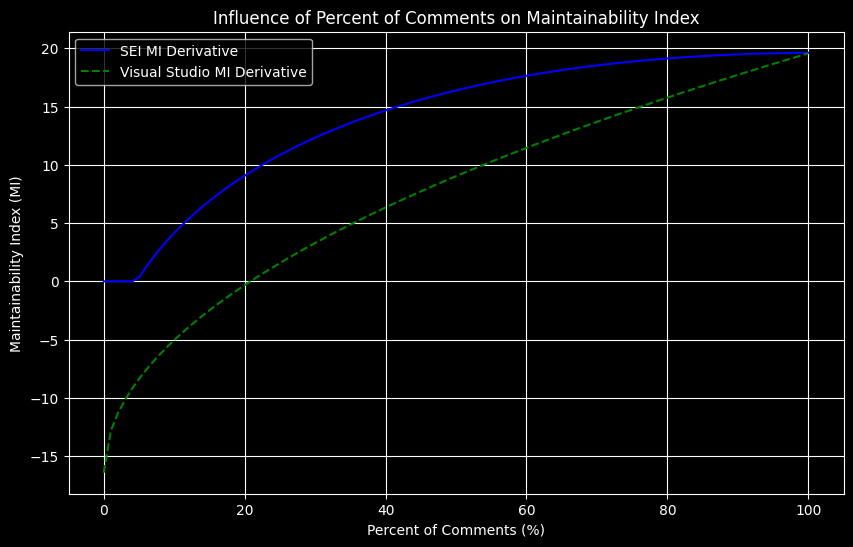

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Define the percentage of comments (as a range from 0% to 100%)
percent_comments = np.linspace(0, 100, 100)

# Define constants for the SEI and Visual Studio MI formulas
# These are placeholders; replace them with actual coefficients if available
V = 1000  # Cyclomatic complexity
G = 10   # Halstead effort
L = 10000  # Lines of code
C = percent_comments / 100  # Convert percentage to a fraction

# Compute the SEI MI derivative
MI_SEI = np.maximum(0, (171 - 5.2 * np.log(V) - 0.23 * G - 16.2 * np.log(L) + 50 * np.sin(np.sqrt(2.4 * C))) / 171 * 100)

# Compute the Visual Studio MI derivative (simplified version)
MI_VS = 171 - 5.2 * np.log(V) - 0.23 * G - 16.2 * np.log(L) + 36 * np.sqrt(C)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(percent_comments, MI_SEI, label="SEI MI Derivative", color="blue")
plt.plot(percent_comments, MI_VS, label="Visual Studio MI Derivative", color="green", linestyle="--")

# Add labels, title, and legend
plt.title("Influence of Percent of Comments on Maintainability Index")
plt.xlabel("Percent of Comments (%)")
plt.ylabel("Maintainability Index (MI)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [1]:
from pylint.reporters.base_reporter import BaseReporter

class ScoreOnlyReporter(BaseReporter):
    def __init__(self, output = None) -> None:
        super().__init__(output)
        self.name = "score-only"
    
    def handle_message(self, msg):
        pass

    def writeln(self, string = ""):
        pass

    def display_reports(self, layout):
        pass

    def on_close(self, stats, previous_stats):
        return stats.global_note

In [2]:
from pylint.lint import Run
import os
# Get the maintainability index for a given source code file
import os
import subprocess
from radon.metrics import mi_visit
import re

def get_maintainability_index(source_code, filepath='temp_code.py'):
    try:
        return mi_visit(source_code, True)
    except Exception as e:
        filename = filepath.split('/')[-1]
        with open(filename, "w") as f:
            f.write(source_code)
        result = subprocess.run(
            ['python2', '-m' 'radon', "mi", "-s", filename],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        maintainability_output = result.stdout
        match_mi = re.search(r"\((\d+)\)", maintainability_output)
        if match_mi:
            os.remove(filename)
            return int(match_mi.group(1))
        else:
            raise Exception(f"File at {filepath} does not compile: {result.stderr}")
        
def get_pylint_score(source_code, filepath='temp_code.py'):
    filename = filepath.split("/")[-1]
    with open(filename, 'w') as f:
        f.write(source_code)
    try:
        pylint_results = Run([filename], ScoreOnlyReporter(), exit=False)
        os.remove(filename)
        return pylint_results.linter.stats.global_note
    except Exception as e:
        raise Exception(f"File at {filepath} does not compile: {e}")

In [3]:
from pydriller import Repository
from datetime import datetime, timedelta
import pymongo

# Connect to MongoDB
myclient = pymongo.MongoClient("mongodb://localhost:27017/")

# Define the repository parameters
repo_name = "matplotlib"
repo_path = f"/Users/as/Library/Mobile Documents/com~apple~CloudDocs/Dokumente/Studium/Bachelor-Thesis/tmp/{repo_name}"
end_date = datetime.now() - timedelta(days=1*50)
start_date = end_date - timedelta(days=1*50)

ocdb = myclient["OCEL"]

# Go through commits in the repository
for commit in Repository(repo_path, since=start_date, to=end_date, only_modifications_with_file_types=[".py"], num_workers=4).traverse_commits():
    file_mis = []
    file_pylints = []
    # Go through modified files in the commit
    for modified_file in commit.modified_files:
        if modified_file.source_code is None or not modified_file.new_path.endswith(".py"):
            continue
        # Calculate code quality metrics
        file_mis.append(get_maintainability_index(modified_file.source_code)/100)
        file_pylints.append(get_pylint_score(modified_file.source_code)/10)
    
        # Create a dictionary for the commit
        type = "commit"
        commit_dict = {
            "commit_date": commit.committer_date,
            "commit_author": commit.author.name,
            "commit_message": commit.msg,
            "file_path": modified_file.new_path,
            "commit_mi": sum(file_mis)/len(file_mis) if file_mis else 0,
            "commit_pylint": sum(file_pylints)/len(file_pylints) if file_pylints else 0,
        }
        ocdb[repo_name].replace_one({"_id": commit.hash}, {"type": type, "attributes": commit_dict})

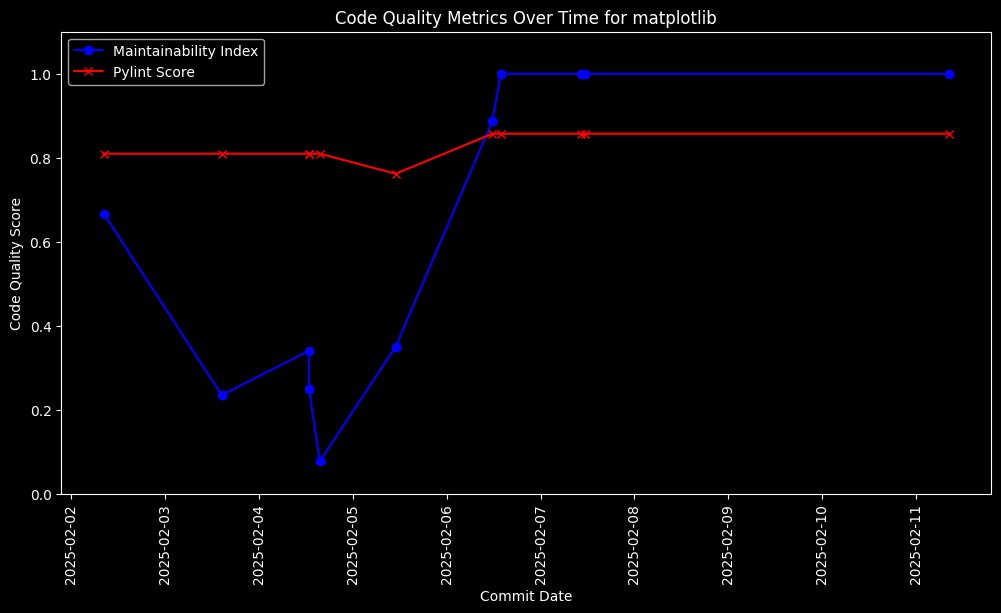

In [4]:
from matplotlib import pyplot as plt
import numpy as np
collection = ocdb[repo_name]
# Query the data
data = collection.find({"type": "commit"}, {"attributes.commit_date": 1, "attributes.commit_mi": 1, "attributes.commit_pylint": 1})

# Extract commit_dates and maintainability indices
commit_dates = []
maintainability_indices = []
commit_pylints = []

for record in data:
    if "attributes" in record:
        attributes = record["attributes"]
        if "commit_date" in attributes and "commit_mi" in attributes and "commit_pylint" in attributes:
            commit_dates.append(attributes["commit_date"])
            maintainability_indices.append(attributes["commit_mi"])
            commit_pylints.append(attributes["commit_pylint"])
        else:
            print(f"Missing data in attributes: {attributes}")
    else:
        print(f"Missing attributes in record: {record}")

sorted_mis = sorted(zip(commit_dates, maintainability_indices), key=lambda x: x[0])
commit_dates, maintainability_indices = zip(*sorted_mis)
sorted_pylints = sorted(zip(commit_dates, commit_pylints), key=lambda x: x[0])
commit_dates, commit_pylints = zip(*sorted_pylints)

# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(commit_dates, maintainability_indices, label="Maintainability Index", color="blue", marker="o", linestyle="-")
plt.plot(commit_dates, commit_pylints, label="Pylint Score", color="red", marker="x", linestyle="-")
plt.xlabel("Commit Date")
plt.ylabel("Code Quality Score")
plt.title(f"Code Quality Metrics Over Time for {repo_name}")
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.ylim(0, 1.1)
plt.legend()
plt.xticks(rotation=90)
plt.show()